# NEVH - Numerical Evolution from the Hamiltonian (V2)

In [1]:
import sys
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#The following line makes modules in src/ accessible from the (current) test/ dir
sys.path.append("../src")
import nevh

## Simple Harmonic Motion

In [2]:
def H(t,psi,k,m):
    x, p = psi
    return 0.5*k*x**2 + 0.5*p**2/m

In [3]:
psi0 = np.array([0.5,0])
dpsi = np.ones(2)*0.1
# With k=4\pi^2, m=1, the period is 1
kc = 4 * np.pi**2
mc = 1
tmin = 0; tmax = 10
G = nevh.Hgrad(H, dpsi, k=kc, m=mc)
trj = solve_ivp(G, [tmin, tmax],psi0,max_step=0.05)

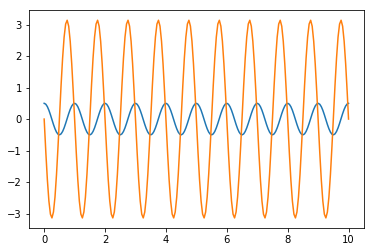

In [4]:
plt.plot(trj.t, trj.y[0], trj.t, trj.y[1]);

## Two equal coupled oscilators

Two equal masses coupled to each other and to opposing walls of a box with equal springs.

In [5]:
def H2(t,s,k,m,L):
    x1, x2, p1, p2 = s
    U = 0.5 * k * ( (x1 + L/6)**2 + (x2-x1 - L/3)**2 + (x2 - L/6)**2)
    T = 0.5 * (p1**2 + p2**2) / m
    return T + U

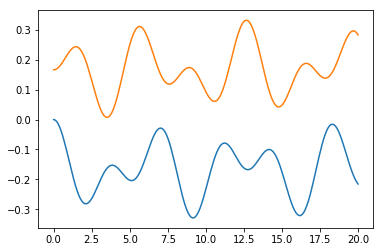

In [20]:
s0 = np.array([0, 1./6, 0., 0.])   # Initial state
ds = np.ones(4) * 0.02             # Spatial discretization step 
kc = 1.0                           # Elastic constant
mc = 1.0                           # Mass
Lc = 1.0                           # Rest separation
tmin = 0.0; tmax = 20.0
F = nevh.Hgrad(H2, ds, k=kc, m=mc, L=Lc)
T = solve_ivp(F, [tmin, tmax], s0, max_step=0.1)
plt.plot(T.t, T.y[0], T.t, T.y[1]);

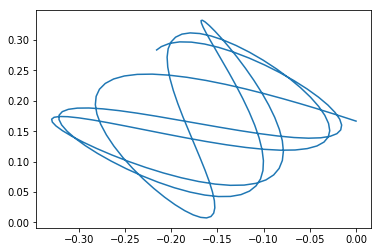

In [21]:
plt.plot(T.y[0],T.y[1]); # Phase space trajectory of m1

## Elastic pendulum

In [22]:
from math import cos
def H3(t,s,m,g,l0,k):
    l, q, pl, pq = s
    T = (0.5 / m) * (pl**2 + (pq / l)**2)
    U = -m * g * l * cos(q) + 0.5 * k * (l - l0)**2
    return T + U

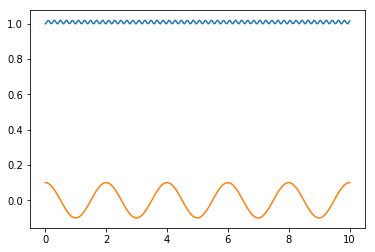

In [27]:
s0 = np.array([1.0, 0.1, 0.0, 0.0])
ds = np.ones(4)*0.1
mc = 1.0; gc = 10.0; l0c = 1.0; kc = 1000.0
F3 = nevh.Hgrad(H3, ds, k=kc, m=mc, l0=l0c, g=gc)
tmin = 0.0; tmax = 10.0
T = solve_ivp(F3, [tmin, tmax], s0, max_step=0.05)
t = T.t
l, theta = T.y[:2]
plt.plot(t, l, t, theta);


### Two body grav, CM frame, crazy units

In [28]:
G = 1
def H4(t, s, M, mu):
    x, y, px, py = s
    V = -G * mu * M / (np.sqrt(x**2 + y**2))
    T = 1/(2 * mu) * (px**2 + py**2)
    return T + V

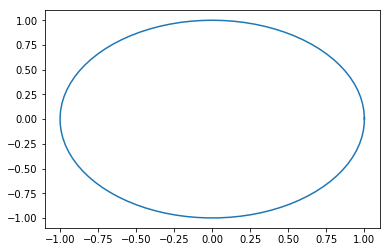

In [43]:
total_mass = 2.0
reduced_mass = 0.5
r0 = 1.0
p0 = reduced_mass * (total_mass/r0)**0.5
s0 = np.array ([r0, 0, 0, p0])
ds = np.ones(4)*0.1
F4 = nevh.Hgrad(H4, ds, M=total_mass, mu=reduced_mass)
tmin = 0.0; tmax = 4.45
T = solve_ivp(F4, [tmin, tmax], s0, max_step=0.05)
t = T.t
x,y = T.y[:2]
plt.plot(x,y);